In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
def plot_img(img, cmap='gray'):
    plt.figure(figsize=(10,6))
    plt.imshow(img, cmap=cmap)
    plt.axis('off')
    plt.show()

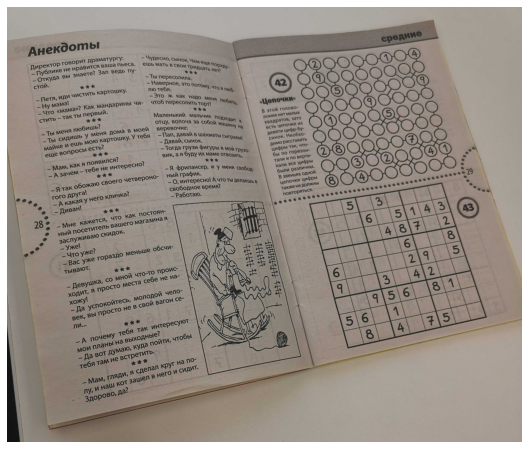

In [ ]:
img = cv2.imread('train_8.jpg')
#img = img[..., ::-1]
plot_img(img[..., ::-1]) 

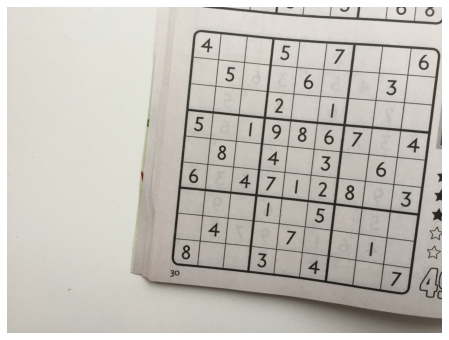

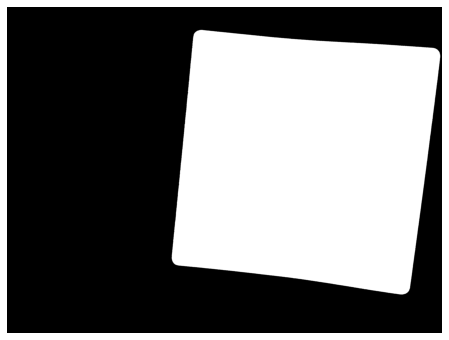

CPU times: user 2.02 s, sys: 0 ns, total: 2.02 s
Wall time: 2.03 s


In [ ]:
%%time
img = cv2.imread('train_8.jpg')
plot_img(img[..., ::-1])

img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
greymain = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
mask = np.zeros((greymain.shape),np.uint8)

th2 = cv2.adaptiveThreshold(greymain,255,cv2.ADAPTIVE_THRESH_MEAN_C,\
            cv2.THRESH_BINARY_INV,39,10)


contours,heirarchy = cv2.findContours(th2,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)

areas = []


for i in range(len(contours)):
    area = cv2.contourArea(contours[i])
    if area > 600000:
      areas.append([area, i])

areas.sort(reverse = True)

cv2.drawContours(mask,[contours[areas[0][1]]],0,255,-1)

for i in range(1,len(areas)):
  if areas[i][0] > 0.5*areas[0][0]:
    cv2.drawContours(mask,[contours[areas[i][1]]],0,255,-1)
mask = mask.astype(np.bool)
plot_img(mask)


In [ ]:
for i in range(len(mask)):
  cur = mask[i]
  for j in range(len(cur)):
    if cur[j] == 255:
      cur[j] = 1
mask = mask.astype(np.bool)

In [ ]:
x = np.load('train_8_mask.npy')
x

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [ ]:
import json
with open('train_1_digits_0.json') as f:
  data = json.load(f)
print(data)

FileNotFoundError: ignored

In [ ]:
from imutils.perspective import four_point_transform
from skimage.segmentation import clear_border
import numpy as np
import imutils

In [ ]:
%%time
img = cv2.imread('train_1.jpg')
#plot_img(img[..., ::-1])

img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
greymain = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)


process = cv2.GaussianBlur(greymain, (15, 15), 0)
process = cv2.adaptiveThreshold(process, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
process = cv2.bitwise_not(process, process)
kernel = np.array([[0., 1., 0.], [1., 1., 1.], [0., 1., 0.]], np.uint8)
process = cv2.dilate(process, kernel)


mask = np.zeros((greymain.shape),np.uint8)

th2 = cv2.adaptiveThreshold(greymain,255,cv2.ADAPTIVE_THRESH_MEAN_C,\
            cv2.THRESH_BINARY_INV,39,10)


contours,heirarchy = cv2.findContours(th2,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)

areas = []
# initialize a contour that corresponds to the puzzle outline

for i in range(len(contours)):
    area = cv2.contourArea(contours[i])
    if area > 600000:
      areas.append([area, i])

#image = cv2.drawContours(blank,[cnt],-1,(255,255,255),2)

areas.sort(reverse = True)

fin_indices = []
fin_indices.append(areas[0][1])

cv2.drawContours(mask,[contours[areas[0][1]]],-1,(255,255,255),2)


for i in range(1,len(areas)):
  if areas[i][0] > 0.5*areas[0][0]:
    cv2.drawContours(mask,[contours[areas[i][1]]],-1,(255,255,255),2)
    fin_indices.append(areas[i][1])
mask = mask.astype(np.bool)

### digits extraction

peri = cv2.arcLength(contours[fin_indices[0]], True)
approx = cv2.approxPolyDP(contours[fin_indices[0]], 0.02 * peri, True)

puzzle = four_point_transform(img, approx.reshape(4, 2))
warped = four_point_transform(process, approx.reshape(4, 2))


plot_img(warped)
#puzzle = four_point_transform(img, areas[0].reshape(4, 2))
#warped = four_point_transform(greymain, areas[0].reshape(4, 2))
#areas
#plot_img(mask)

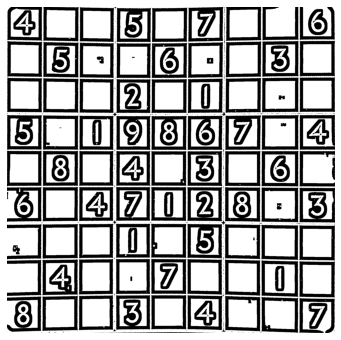

In [ ]:
#warped  = cv2.bitwise_not(cv2.adaptiveThreshold(warped,255,cv2.ADAPTIVE_THRESH_MEAN_C,\
#            cv2.THRESH_BINARY_INV,39,10))
#plot_img(warped)

In [ ]:
def extract_digit(cell):
  # apply automatic thresholding to the cell and then clear any
	# connected borders that touch the border of the cell
  thresh = cv2.threshold(cell, 0, 255, 
                         cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
  thresh = clear_border(thresh)
 
  # find contours in the thresholded cell
  cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,
                          cv2.CHAIN_APPROX_SIMPLE)
  cnts = imutils.grab_contours(cnts)
	
  # if no contours were found than this is an empty cell
  if len(cnts) == 0:
    return None
  
  c = max(cnts, key = cv2.contourArea)
  mask = np.zeros(thresh.shape, dtype = "uint8")
  cv2.drawContours(mask, [c], -1, 255, -1)

  # compute the percentage of masked pixels relative to the total
	# area of the image
  (h, w) = thresh.shape
  percentFilled = cv2.countNonZero(mask) / float(w * h)

  # if less than 3% of the mask is filled then we are looking at
	# noise and can safely ignore the contour
	
  if percentFilled < 0.03:
    return None

  # apply the mask to the thresholded cell  
  digit = cv2.bitwise_and(thresh, thresh, mask=mask)
  # return the digit to the calling function
  return digit

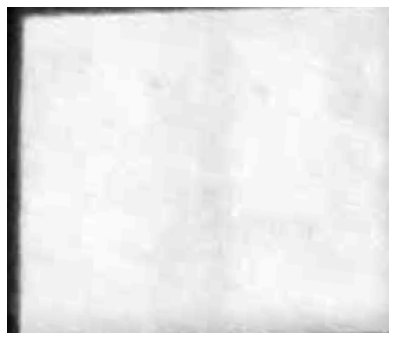

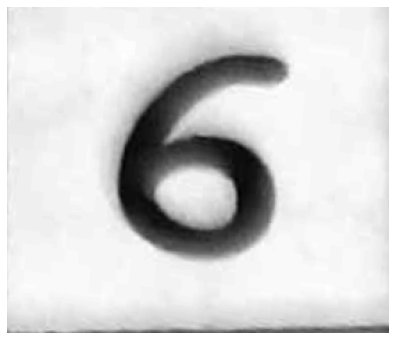

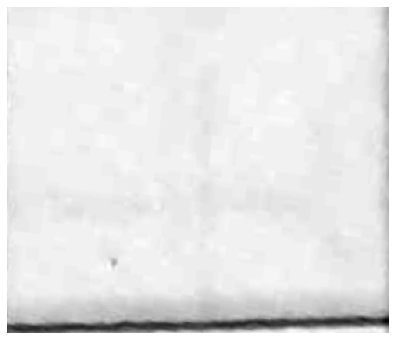

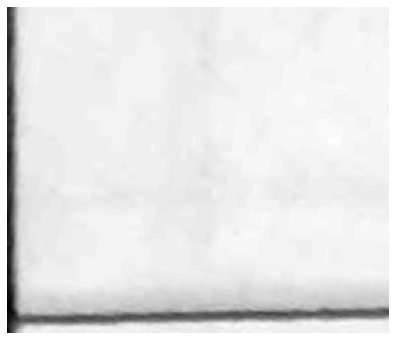

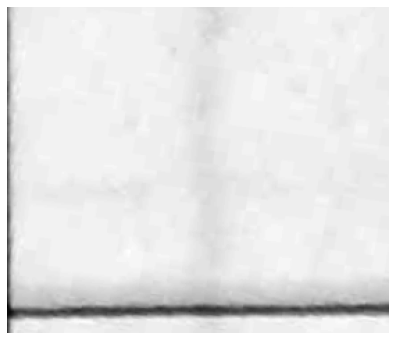

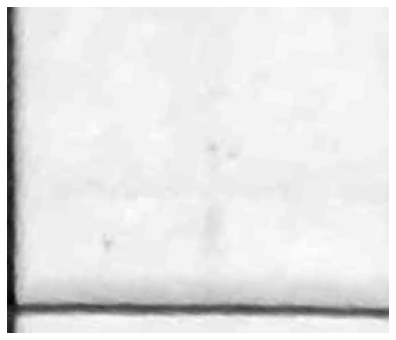

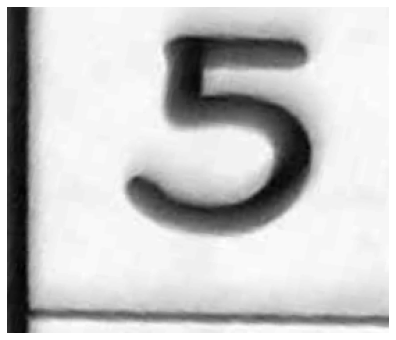

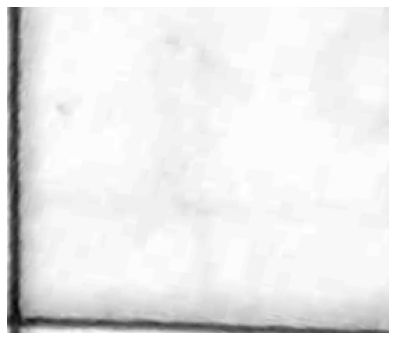

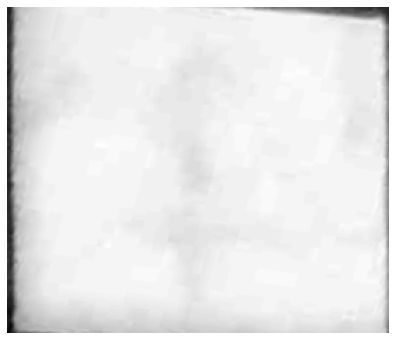

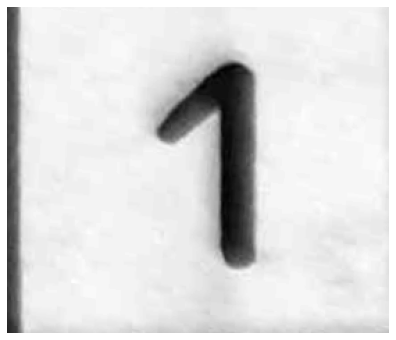

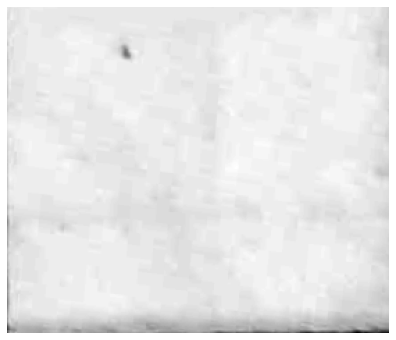

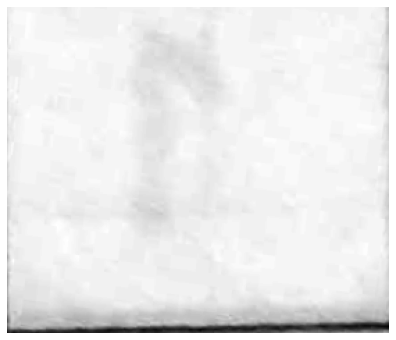

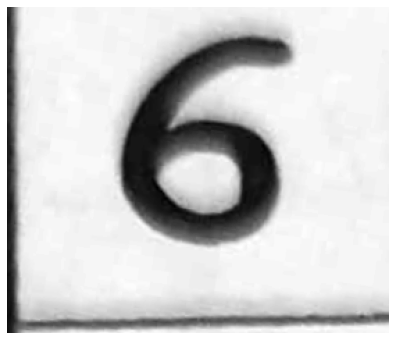

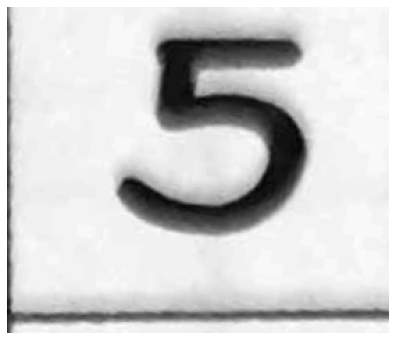

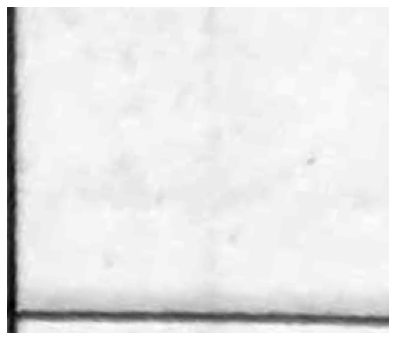

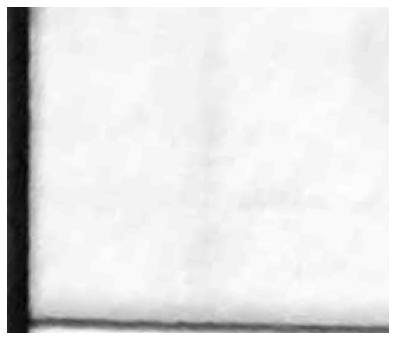

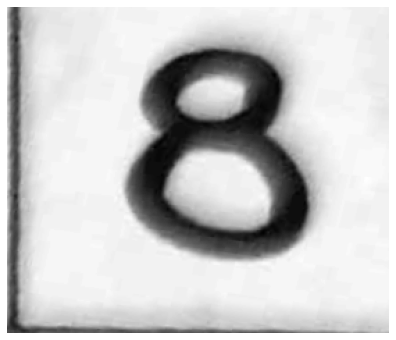

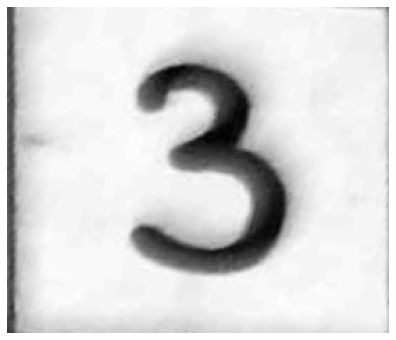

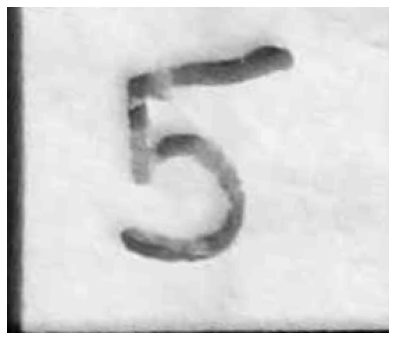

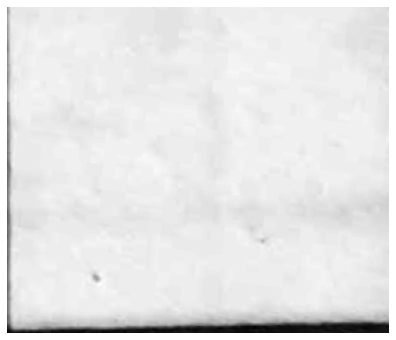

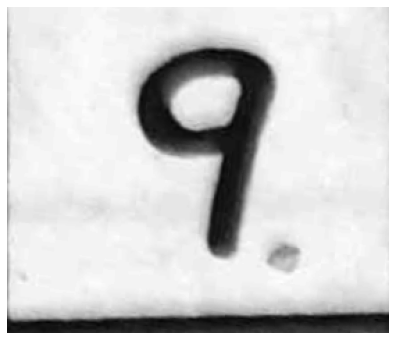

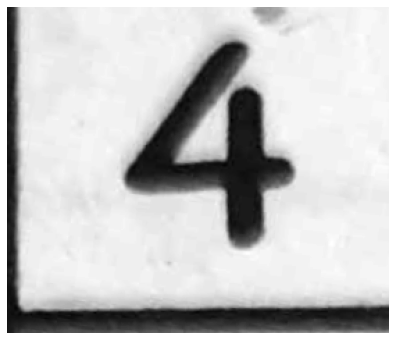

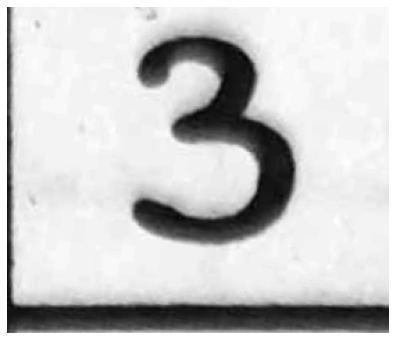

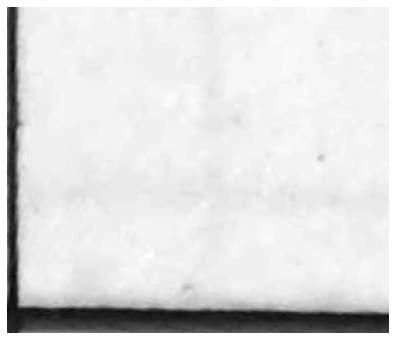

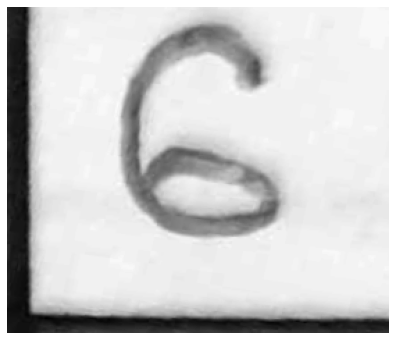

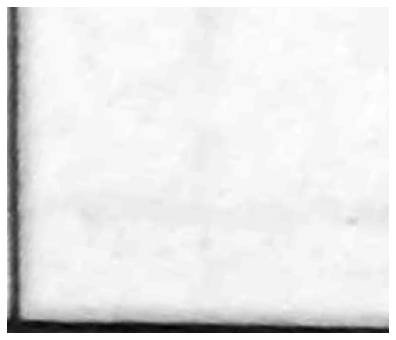

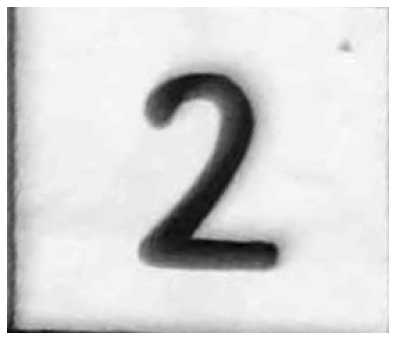

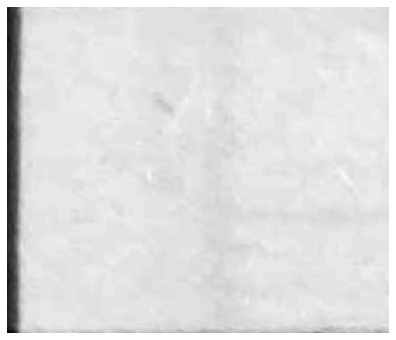

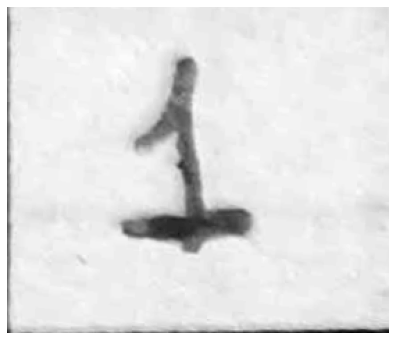

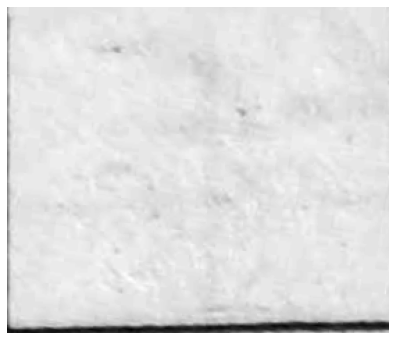

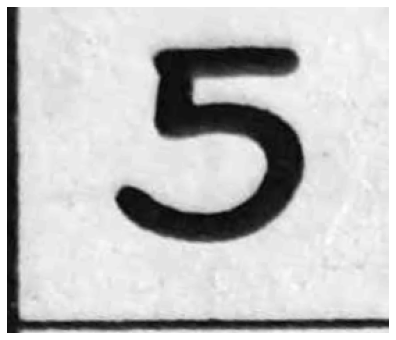

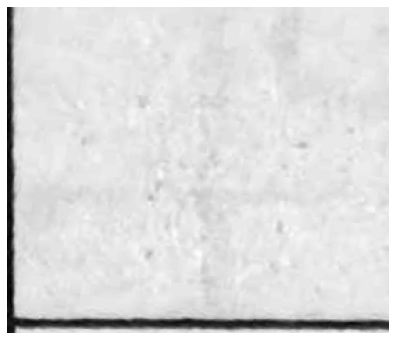

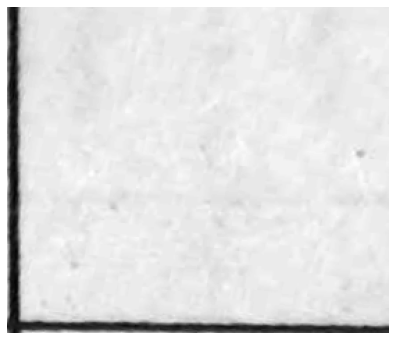

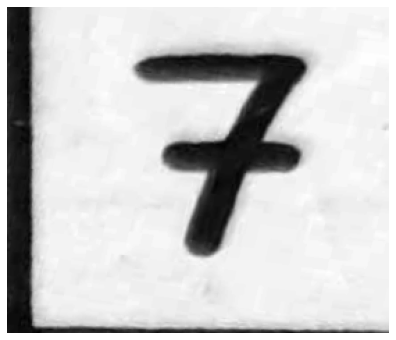

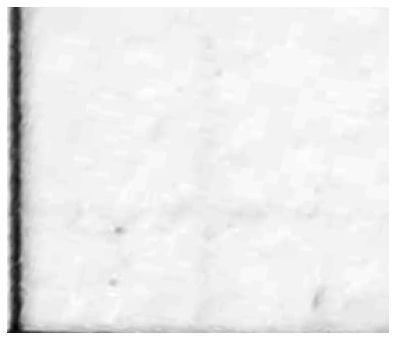

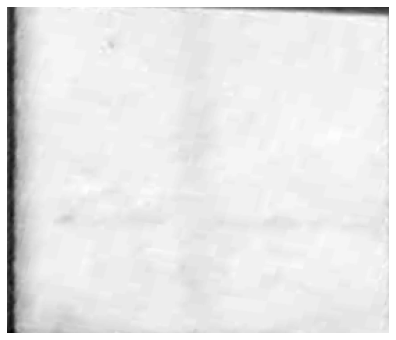

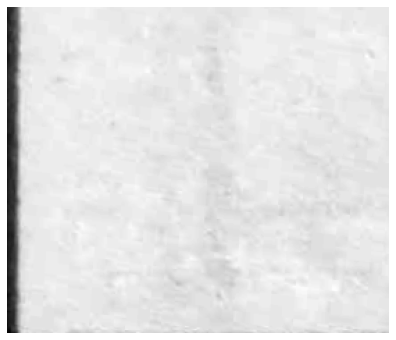

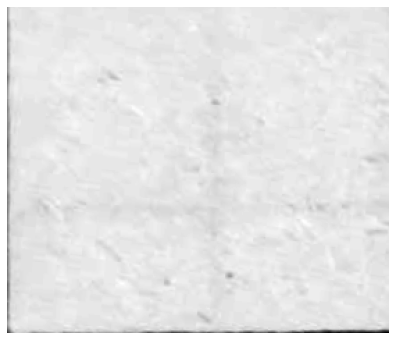

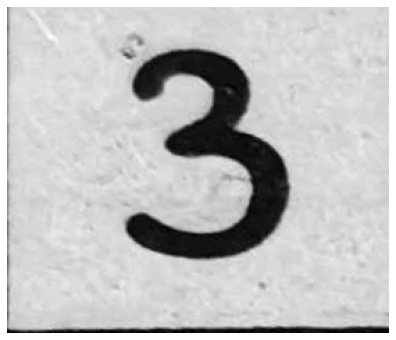

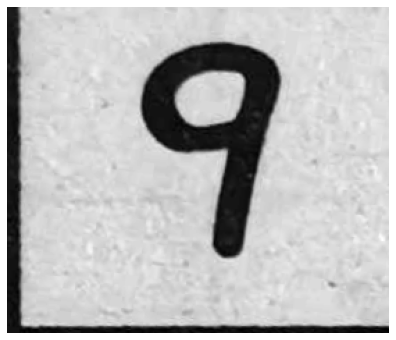

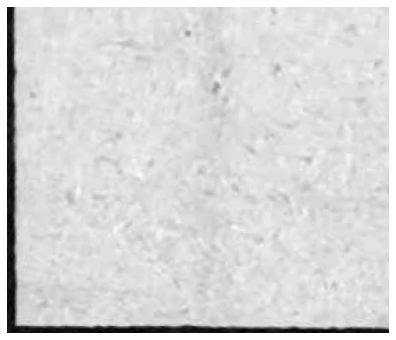

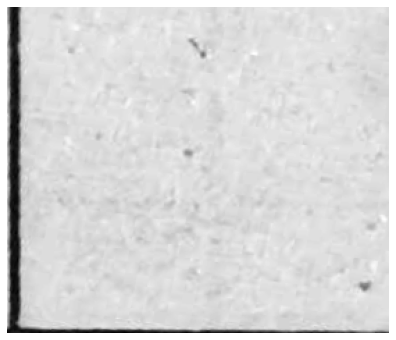

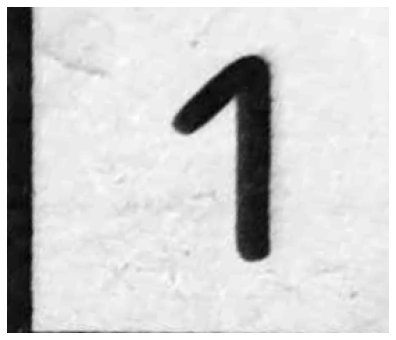

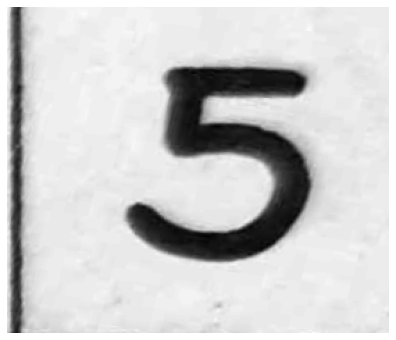

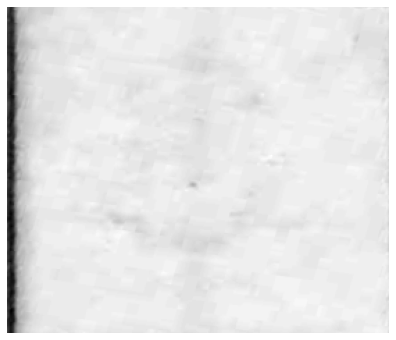

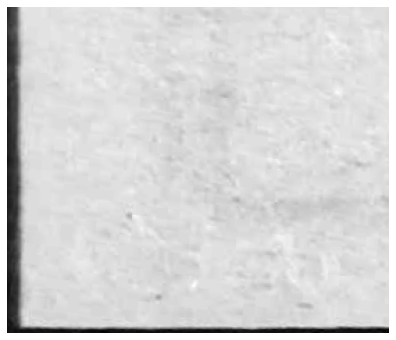

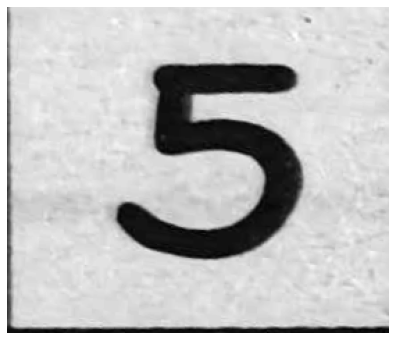

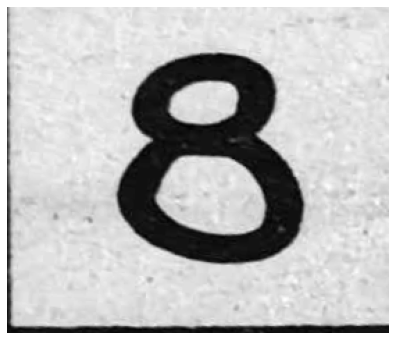

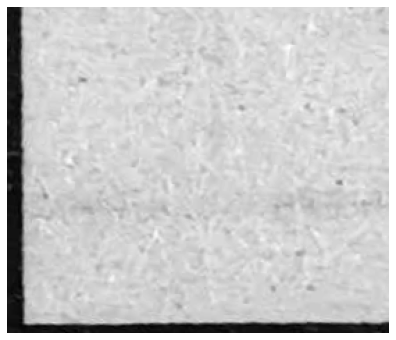

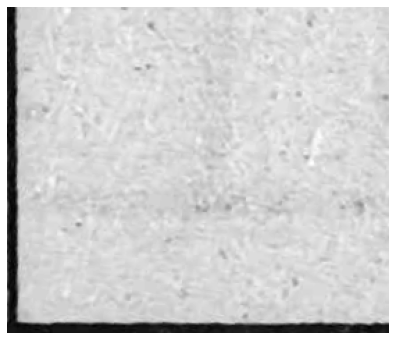

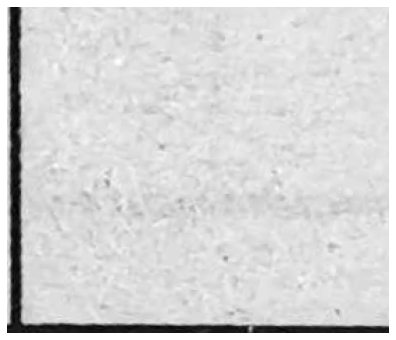

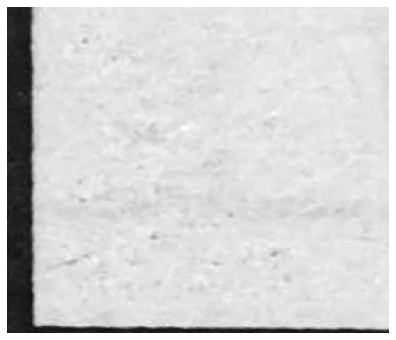

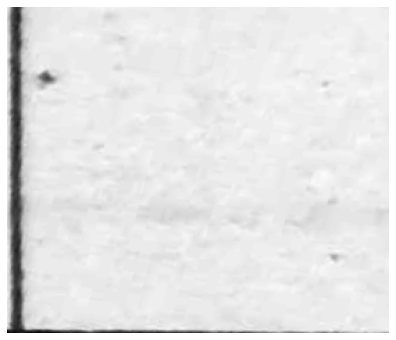

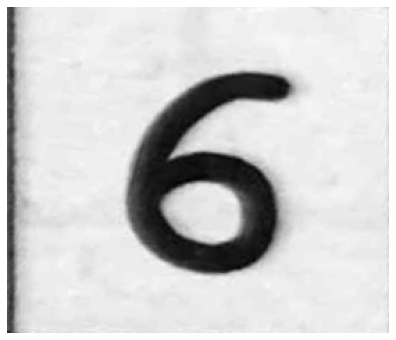

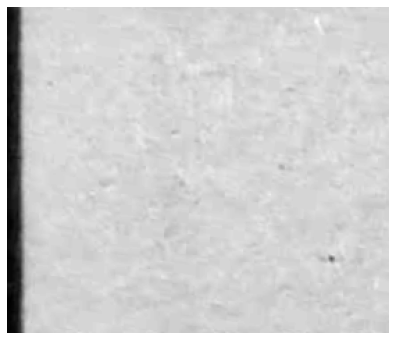

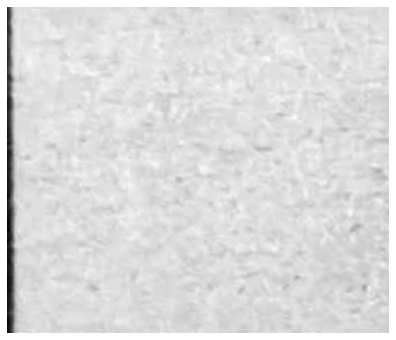

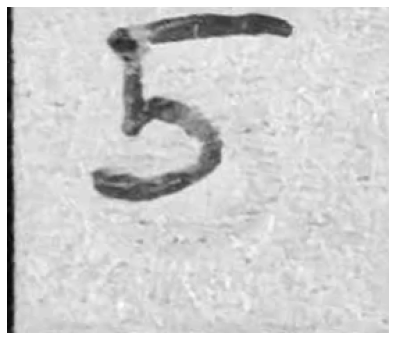

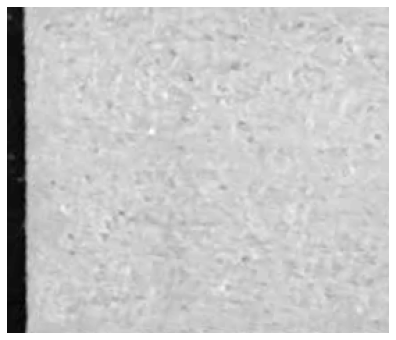

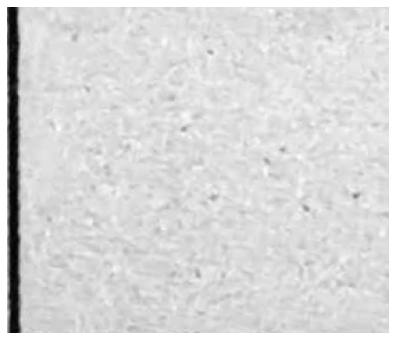

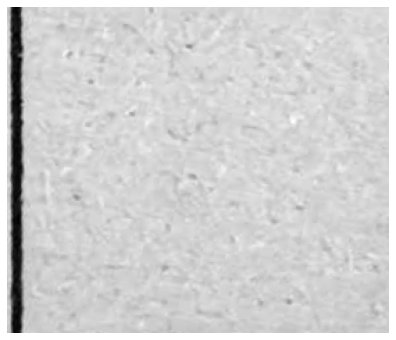

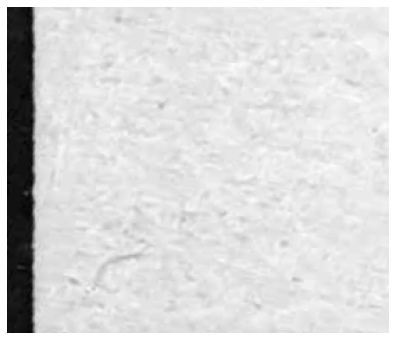

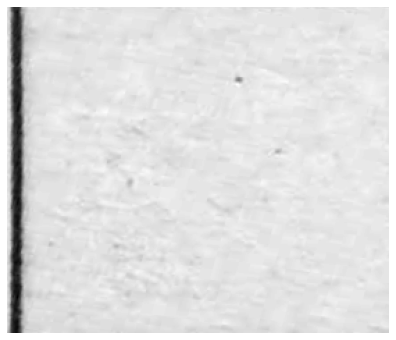

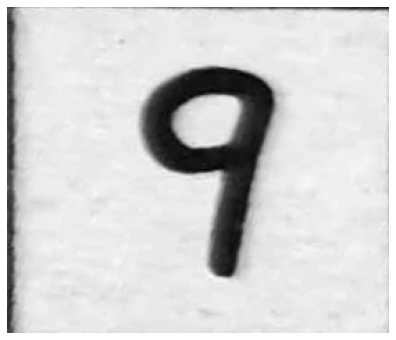

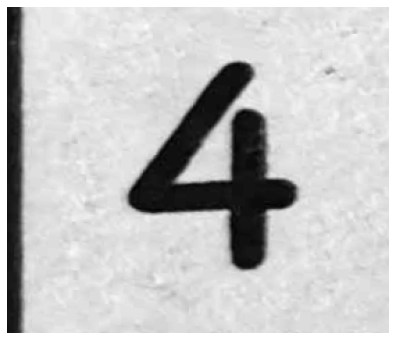

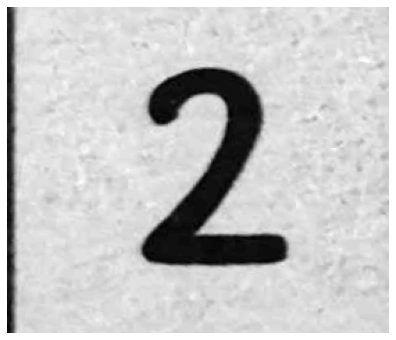

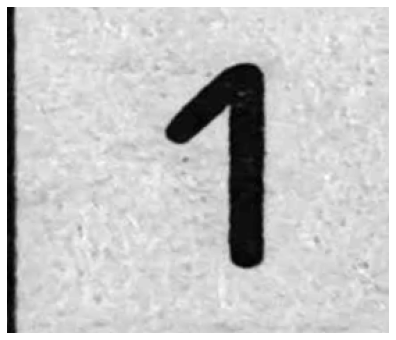

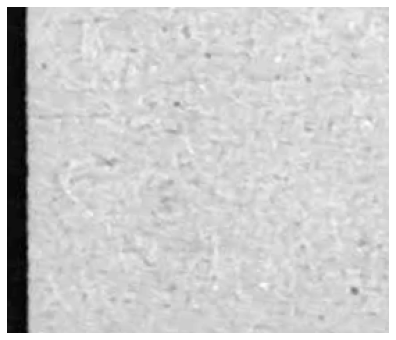

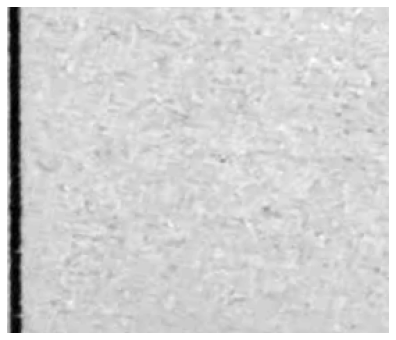

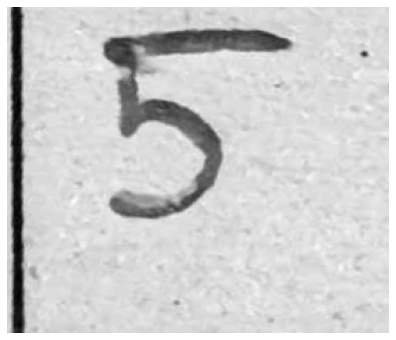

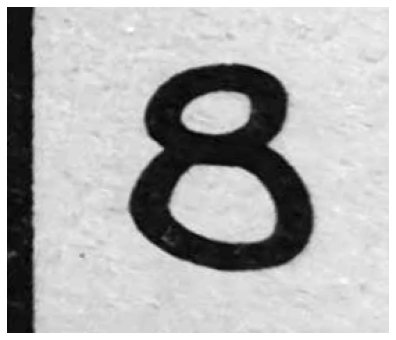

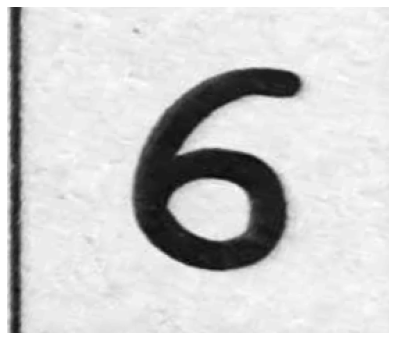

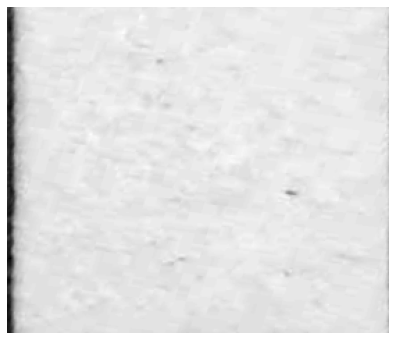

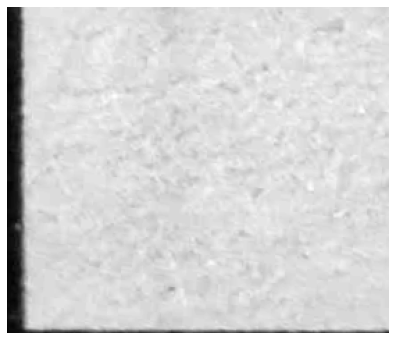

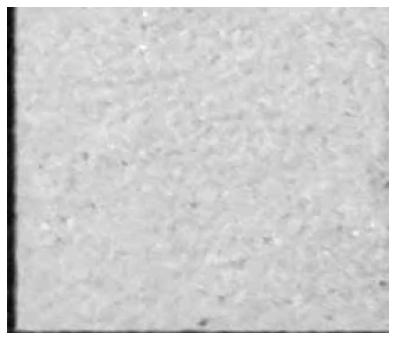

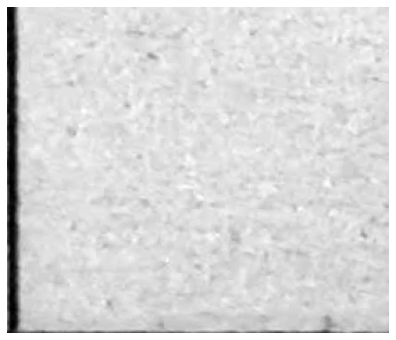

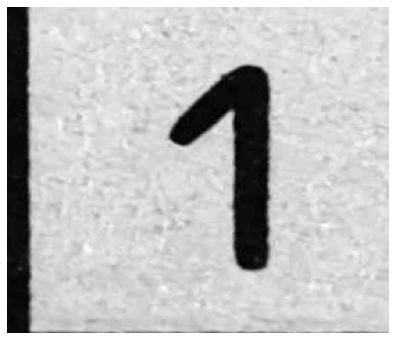

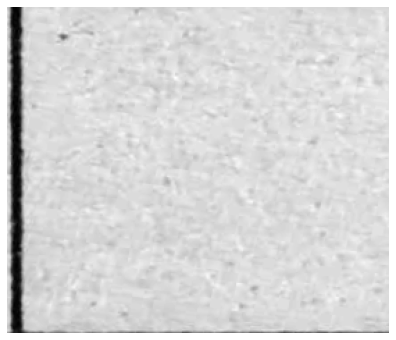

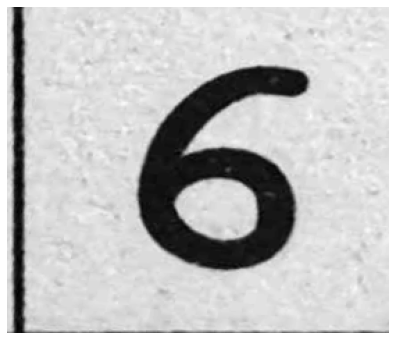

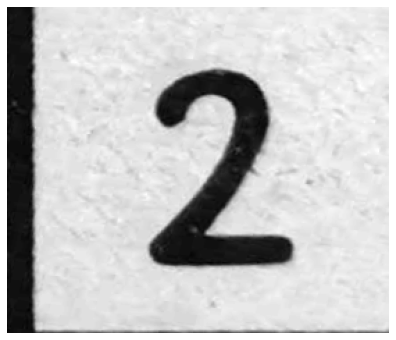

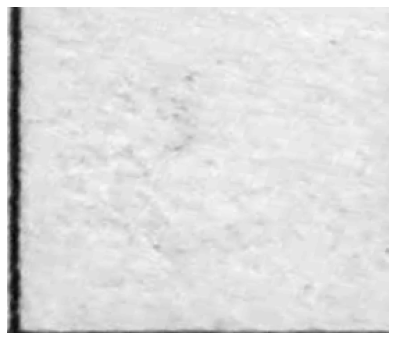

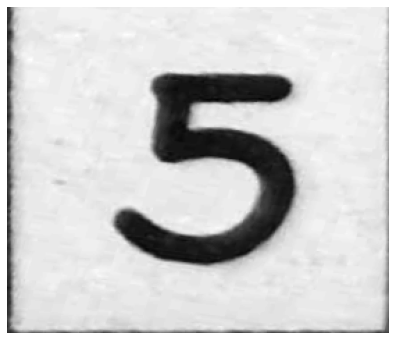

CPU times: user 13.6 s, sys: 174 ms, total: 13.8 s
Wall time: 14 s


In [ ]:
%%time 
from tensorflow import keras
# initialize our 9x9 Sudoku board
board = np.full((9, 9), -1)
# a Sudoku puzzle is a 9x9 grid (81 individual cells), so we can
# infer the location of each cell by dividing the warped image
# into a 9x9 grid
stepX = warped.shape[1] // 9
stepY = warped.shape[0] // 9
# initialize a list to store the (x, y)-coordinates of each cell
# location
cellLocs = []

model = keras.models.load_model("my_model_2")

# loop over the grid locations
for y in range(0, 9):
  # initialize the current list of cell locations
  row = []
  for x in range(0, 9):
    # compute the starting and ending (x, y)-coordinates of the
    # current cell
    startX = x * stepX
    startY = y * stepY
    endX = (x + 1) * stepX
    endY = (y + 1) * stepY
    # add the (x, y)-coordinates to our cell locations list
    row.append((startX, startY, endX, endY))
    # crop the cell from the warped transform image and then
    # extract the digit from the cell
    cell = warped[startY:endY, startX:endX]
    plot_img(cell)
    digit = cell
    if digit is not None:
      roi = cv2.resize(digit, (28, 28))
      roi = roi.astype("float") / 255.0
      roi = img_to_array(roi)
      roi = np.expand_dims(roi, axis=0)
      # classify the digit and update the Sudoku board with the
      # prediction
      pred = model.predict(roi).argmax(axis=1)[0]
      board[y, x] = pred
  cellLocs.append(row)

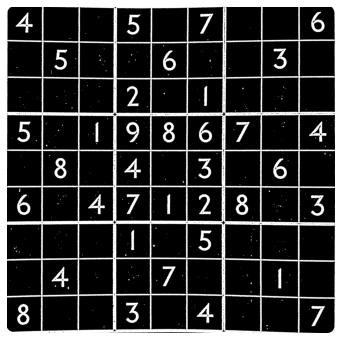

In [ ]:
plot_img(warped)

In [ ]:
board

array([[9, 9, 9, 8, 9, 8, 9, 9, 9],
       [9, 9, 9, 9, 8, 9, 9, 9, 9],
       [8, 0, 9, 8, 9, 8, 9, 1, 1],
       [9, 9, 8, 9, 8, 9, 8, 9, 4],
       [9, 8, 9, 9, 9, 3, 9, 6, 5],
       [6, 9, 4, 8, 8, 8, 8, 9, 9],
       [9, 9, 9, 8, 9, 9, 9, 9, 9],
       [9, 4, 9, 9, 8, 9, 9, 1, 9],
       [8, 9, 9, 3, 5, 4, 9, 9, 9]])

In [ ]:
import tensorflow as tf

# Importing the required Keras modules containing model and layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.layers import Activation


def predict_digit():
  (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
  # Reshaping the array to 4-dims so that it can work with the Keras API
  x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
  x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)
  input_shape = (28, 28, 1)
  # Making sure that the values are float so that we can get decimal points after division
  x_train = x_train.astype('float32')
  x_test = x_test.astype('float32')
  # Normalizing the RGB codes by dividing it to the max RGB value.
  x_train /= 255
  x_test /= 255
  
  # Creating a Sequential Model and adding the layers
  model = Sequential()
  model.add(Conv2D(28, kernel_size=(3,3), input_shape=input_shape))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Flatten()) # Flattening the 2D arrays for fully connected layers
  model.add(Dense(128, activation=tf.nn.relu))
  model.add(Dropout(0.2))
  model.add(Dense(10,activation=tf.nn.softmax))
  model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])
  model.fit(x=x_train,y=y_train, epochs = 5)
  model.save("my_model_2")
  #pred = model.predict(digit)
  

In [ ]:
predict_digit()

11501568/11490434 [==============================] - 0s 0us/step
Epoch 1/5
1875/1875 [==============================] - 33s 17ms/step - loss: 0.2129 - accuracy: 0.9359
Epoch 2/5
1875/1875 [==============================] - 32s 17ms/step - loss: 0.0893 - accuracy: 0.9724
Epoch 3/5
1875/1875 [==============================] - 32s 17ms/step - loss: 0.0623 - accuracy: 0.9793
Epoch 4/5
1875/1875 [==============================] - 32s 17ms/step - loss: 0.0456 - accuracy: 0.9851
Epoch 5/5
1875/1875 [==============================] - 32s 17ms/step - loss: 0.0383 - accuracy: 0.9873
INFO:tensorflow:Assets written to: my_model_2/assets


In [ ]:
from tensorflow import keras
reconstructed_model = keras.models.load_model("my_model")